In [1]:
import tensorflow as tf

In [2]:
images=tf.data.Dataset.list_files('PlantVillage/*/*',shuffle=False)
for file in images.take(3):
    print(file.numpy())

b'PlantVillage\\Potato___Early_blight\\001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG'
b'PlantVillage\\Potato___Early_blight\\002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG'
b'PlantVillage\\Potato___Early_blight\\009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG'


In [3]:
images=images.shuffle(2500)
for file in images.take(3):
    print(file.numpy())

b'PlantVillage\\Potato___Early_blight\\107827b3-faa5-457c-97fd-3e34d2657f6b___RS_Early.B 7162.JPG'
b'PlantVillage\\Potato___Late_blight\\146c4ea6-cf74-4607-9b8e-19c69c85ec86___RS_LB 4641.JPG'
b'PlantVillage\\Potato___Late_blight\\87681326-2843-4e63-9042-602b08a98a66___RS_LB 4145.JPG'


In [4]:
len(images)

2152

In [5]:
train_size=int(len(images)*0.8)
train=images.take(train_size)
test=images.skip(train_size)

In [6]:
len(train),len(test)

(1721, 431)

In [7]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

# LOADING AGAIN THE DATASETS

In [8]:
imgsize=256
batch_siz=32
channels=3

In [9]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(imgsize,imgsize),
    batch_size=batch_siz)

Found 2152 files belonging to 3 classes.


In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(imgsize,imgsize),
    batch_size=batch_siz
)

Found 2152 files belonging to 3 classes.


In [11]:
class_names=dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
len(dataset)

68

In [13]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [14]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print("Shape of the image is :",image_batch[0].shape)

[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]
Shape of the image is : (256, 256, 3)


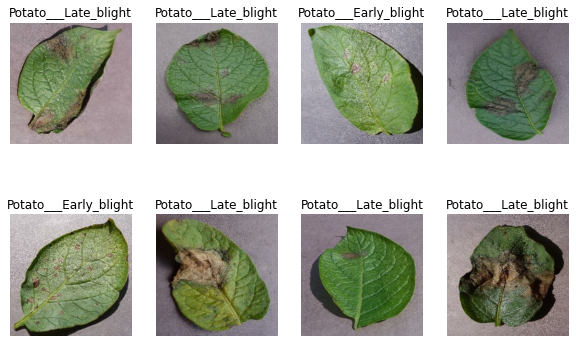

In [15]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(8):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [16]:
len(dataset)

68

In [17]:
EPOCHS=50

In [18]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [19]:
train_ds=dataset.take(54)
len(train_ds)

54

In [20]:
test_ds=dataset.skip(54)

In [21]:
val=0.1
len(dataset)*val

6.800000000000001

In [22]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [23]:
test_ds=test_ds.skip(6)

In [24]:
len(test_ds)

8

In [25]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [26]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [27]:
len(train_ds),len(val_ds)

(54, 6)

In [28]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imgsize,imgsize),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# DATA AUGMENTATION

In [30]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [33]:
input_shape=(batch_siz,imgsize,imgsize,channels)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [34]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [42]:
EPOCHS=15

In [43]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=batch_siz,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/15
54/54 [==============================] - 156s 3s/step - loss: 0.7665 - accuracy: 0.5897 - val_loss: 0.6132 - val_accuracy: 0.7344
Epoch 2/15
54/54 [==============================] - 162s 3s/step - loss: 0.4893 - accuracy: 0.7772 - val_loss: 0.3511 - val_accuracy: 0.8698
Epoch 3/15
54/54 [==============================] - 165s 3s/step - loss: 0.3396 - accuracy: 0.8628 - val_loss: 0.3163 - val_accuracy: 0.8698
Epoch 4/15
54/54 [==============================] - 159s 3s/step - loss: 0.3417 - accuracy: 0.8709 - val_loss: 0.3697 - val_accuracy: 0.8802
Epoch 5/15
54/54 [==============================] - 150s 3s/step - loss: 0.2598 - accuracy: 0.9016 - val_loss: 0.1399 - val_accuracy: 0.9531
Epoch 6/15
54/54 [==============================] - 146s 3s/step - loss: 0.1674 - accuracy: 0.9311 - val_loss: 0.1088 - val_accuracy: 0.9583
Epoch 7/15
54/54 [==============================] - 169s 3s/step - loss: 0.1097 - accuracy: 0.9606 - val_loss: 0.0634 - val_accuracy: 0.9740
Epoch 8/15
54

In [44]:
model.evaluate(test_ds)

8/8 [==============================] - 6s 338ms/step - loss: 0.0104 - accuracy: 1.0000


[0.010433643124997616, 1.0]

In [46]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 7s 877ms/step - loss: 0.0104 - accuracy: 1.0000


In [47]:
scores

[0.010433643124997616, 1.0]

In [48]:
history

In [49]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [50]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [51]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

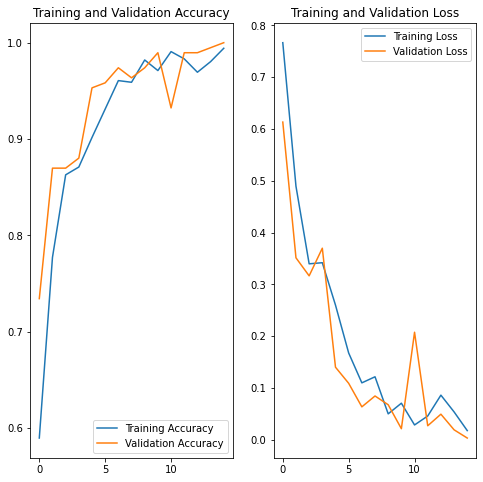

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [55]:
import numpy as np

first image to predict
actual label:  Potato___Late_blight
1/1 [==============================] - 1s 858ms/step
Predicted Class is -->
Potato___Late_blight


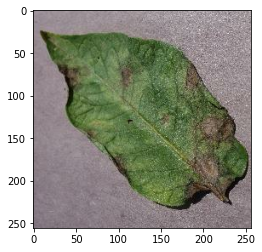

In [59]:
for images_batch ,labels_batch in test_ds.take(1):
    first_image=(images_batch[0].numpy().astype('uint8'))
    first_label=labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ",class_names[first_label])
    model.predict(image_batch)
    batch_prediction=model.predict(images_batch)
    #print(batch_prediction[0])
    print('Predicted Class is -->')
    print(class_names[np.argmax(batch_prediction[0])])
    

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 67ms/step


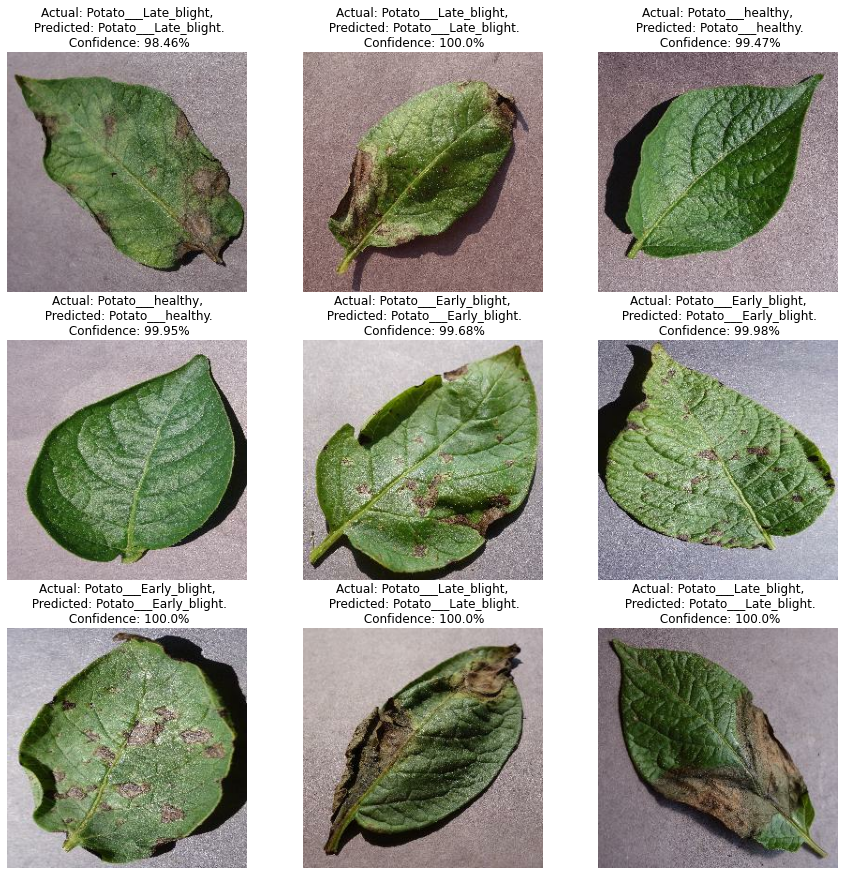

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
